# Setup & Imports

In [ ]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive/', force_remount=True)

In [ ]:
# add all imports needed for notebook to this cell block
from torchvision.datasets import Cityscapes
from torchvision import transforms
from torchvision.transforms import ToTensor
import torch
import matplotlib.pyplot as plt
import numpy as np
import os
import zipfile

In [ ]:
# %cd 'CS242 Group 3'
# !cd /content/drive/.shortcut-targets-by-id/1ewtk1E8X9iB23sxht0mnAmZb7aA7JJW5/CS242

In [ ]:
# Check that the pwd goes to 'CS242 Group 3' (or your Google Drive shortcut to it).
# This folder needs to be the root, otherwise loading in the cityscapes data won't work
!pwd

/content/drive/.shortcut-targets-by-id/1ewtk1E8X9iB23sxht0mnAmZb7aA7JJW5/CS242


In [ ]:
# ls -> should include a directory called 'data'
!ls

'CS242 Final Project.ipynb'		 CS242_PA2.pdf	   data.zip
'CS242 Final Project Proposal.gslides'	 CS242_PA3.ipynb  'Interim Project Presentation.gslides'
'CS242 Group Meeting Notes.gdoc'	 CS242_PA3.pdf	  'Notes from 11 17 Research.gdoc'
 CS242_PA2.ipynb			 data


In [ ]:
# unzip dataset into 'data' folder, will skip if 'data' already exists
zip_file_path = "data.zip"
output_folder = "data"

if os.path.exists(output_folder) and os.listdir(output_folder):
    print(f"Directory '{output_folder}' already exists and contains files. Skipping extraction.")
else:
    os.makedirs(output_folder, exist_ok=True)

    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(output_folder)

    print(f"Extracted files into '{output_folder}'")

Directory 'data' already exists and contains files. Skipping extraction.


## Test Load Image & Label Map

In [ ]:
# Define a transform for data augmentation and normalization
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.2869, 0.3251, 0.2837), std=(0.1867, 0.1908, 0.1879)),
])

# Specify dataset paths
cityscapes_dataset = Cityscapes(
    root='data',
    split='train',            # Options: 'train', 'val', 'test'
    mode='fine',              # Options: 'fine', 'coarse'
    target_type='semantic',   # Options: 'instance', 'semantic', 'polygon', 'color'
    transform=transform
)

image, label = cityscapes_dataset[0]

# Convert PIL images to tensors if needed
image_tensor = ToTensor()(image) if not isinstance(image, torch.Tensor) else image
label_tensor = ToTensor()(label) if not isinstance(label, torch.Tensor) else label

print(image_tensor.shape, label_tensor.shape)

##### SANITY CHECK #####
# image.shape should return (3, height, width) (for RGB images).
# label.shape should return (1, height, width) or (height, width).

torch.Size([3, 1024, 2048]) torch.Size([1, 1024, 2048])


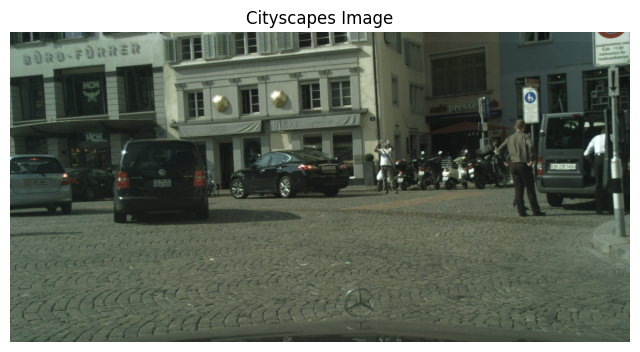

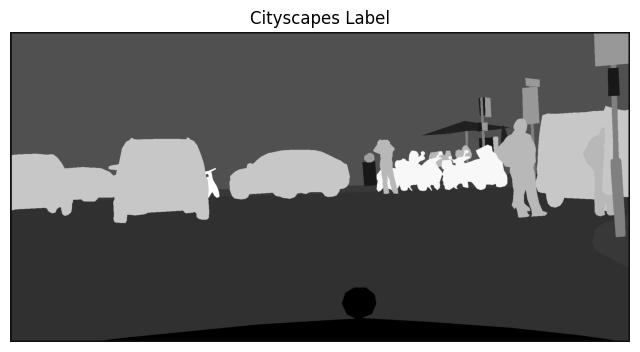

In [ ]:
# Unnormalize the image tensor for visualization
def unnormalize(tensor, mean, std):
    mean = np.array(mean)
    std = np.array(std)
    tensor = tensor.numpy().transpose(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
    tensor = (tensor * std) + mean  # Reverse normalization
    tensor = np.clip(tensor, 0, 1)  # Clip values to range [0, 1]
    return tensor

# Unnormalize and display the image
image = unnormalize(image_tensor, mean=(0.2869, 0.3251, 0.2837), std=(0.1867, 0.1908, 0.1879))

# Display the image
plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.axis('off')
plt.title("Cityscapes Image")
plt.show()

# Display the label
plt.figure(figsize=(8, 8))
plt.imshow(label_tensor.squeeze(), cmap='gray')
plt.axis('off')
plt.title("Cityscapes Label")
plt.show()


## Cloning Git Repo
Do not re-run this section.

In [ ]:
!git --version

git version 2.34.1


In [ ]:
!git config --global core.compression 0

In [ ]:
##### DO NOT RE-RUN #####
# !git clone --depth 1 https://github.com/ColeHarten/variable-depth-attention-unet.git

Cloning into 'variable-depth-attention-unet'...
remote: Enumerating objects: 69, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 69 (delta 12), reused 46 (delta 5), pack-reused 0 (from 0)
Receiving objects: 100% (69/69), 381.93 KiB | 1.34 MiB/s, done.
Resolving deltas: 100% (12/12), done.


In [2]:
import numpy
from torch.utils.data import DataLoader
from tqdm import tqdm

from dataio.loader import get_dataset, get_dataset_path
from dataio.transformation import get_dataset_transformation
from utils.util import json_file_to_pyobj
from utils.visualiser import Visualiser
from utils.error_logger import ErrorLogger

from models import get_model

In [3]:
def train(arguments):
    # Parse input arguments
    json_filename = arguments.config
    network_debug = arguments.debug

    # Load options
    json_opts = json_file_to_pyobj(json_filename)
    train_opts = json_opts.training

    # Architecture type
    arch_type = train_opts.arch_type

    # Setup Dataset and Augmentation
    ds_class = get_dataset(arch_type)
    ds_path  = get_dataset_path(arch_type, json_opts.data_path)
    ds_transform = get_dataset_transformation(arch_type, opts=json_opts.augmentation)

    # Setup the NN Model
    model = get_model(json_opts.model)
    if network_debug:
        print('# of pars: ', model.get_number_parameters())
        print('fp time: {0:.3f} sec\tbp time: {1:.3f} sec per sample'.format(*model.get_fp_bp_time()))
        exit()

    # Setup Data Loader
    train_dataset = ds_class(ds_path, split='train',      transform=ds_transform['train'], preload_data=train_opts.preloadData)
    valid_dataset = ds_class(ds_path, split='validation', transform=ds_transform['valid'], preload_data=train_opts.preloadData)
    test_dataset  = ds_class(ds_path, split='test',       transform=ds_transform['valid'], preload_data=train_opts.preloadData)
    train_loader = DataLoader(dataset=train_dataset, num_workers=16, batch_size=train_opts.batchSize, shuffle=True)
    valid_loader = DataLoader(dataset=valid_dataset, num_workers=16, batch_size=train_opts.batchSize, shuffle=False)
    test_loader  = DataLoader(dataset=test_dataset,  num_workers=16, batch_size=train_opts.batchSize, shuffle=False)

    # Visualisation Parameters
    visualizer = Visualiser(json_opts.visualisation, save_dir=model.save_dir)
    error_logger = ErrorLogger()

    # Training Function
    model.set_scheduler(train_opts)
    for epoch in range(model.which_epoch, train_opts.n_epochs):
        print('(epoch: %d, total # iters: %d)' % (epoch, len(train_loader)))

        # Training Iterations
        for epoch_iter, (images, labels) in tqdm(enumerate(train_loader, 1), total=len(train_loader)):
            # Make a training update
            model.set_input(images, labels)
            model.optimize_parameters()
            #model.optimize_parameters_accumulate_grd(epoch_iter)

            # Error visualisation
            errors = model.get_current_errors()
            error_logger.update(errors, split='train')

        # Validation and Testing Iterations
        for loader, split in zip([valid_loader, test_loader], ['validation', 'test']):
            for epoch_iter, (images, labels) in tqdm(enumerate(loader, 1), total=len(loader)):

                # Make a forward pass with the model
                model.set_input(images, labels)
                model.validate()

                # Error visualisation
                errors = model.get_current_errors()
                stats = model.get_segmentation_stats()
                error_logger.update({**errors, **stats}, split=split)

                # Visualise predictions
                visuals = model.get_current_visuals()
                visualizer.display_current_results(visuals, epoch=epoch, save_result=False)

        # Update the plots
        for split in ['train', 'validation', 'test']:
            visualizer.plot_current_errors(epoch, error_logger.get_errors(split), split_name=split)
            visualizer.print_current_errors(epoch, error_logger.get_errors(split), split_name=split)
        error_logger.reset()

        # Save the model parameters
        if epoch % train_opts.save_epoch_freq == 0:
            model.save(epoch)

        # Update the model learning rate
        model.update_learning_rate()

In [ ]:
if __name__ == '__main__':
    # import argparse

    # parser = argparse.ArgumentParser(description='CNN Seg Training Function')

    # parser.add_argument('-c', '--config',  help='training config file', required=True)
    # parser.add_argument('-d', '--debug',   help='returns number of parameters and bp/fp runtime', action='store_true')
    # args = parser.parse_args()

    class Args:
        config = "configs/config_sononet_8.json"
        debug = True

    # Create an instance of the Args class
    args = Args()

    train(args)



############# Augmentation Parameters #############
{'division_factor': (16, 16, 1),
 'inten_val': (1.0, 1.0),
 'name': 'us',
 'patch_size': [208, 272],
 'random_flip_prob': 0.5,
 'rotate_val': 15.0,
 'scale_size': (192, 192, 1),
 'scale_val': (0.7, 1.3),
 'shift_val': (0.1, 0.1)}
###################################################




AttributeError: module 'torchsample' has no attribute 'Compose'